In [1]:
import sys
sys.path.append('../')
from read_data_functions import *
from plot_functions import *
from calculations import *
plt.style.use('../Style.mplstyle')
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # suppress warnings

In [2]:
path = '../../../Data/2025/08 - August/'
AMS_paths = ['250820_sabinene_O3_20C/', '250822_Sabinene_100ppb_0C/', '250825_Sabinene_100ppb_10C/', 
             '250826_Sabinene_100ppb_neg10C/', '250828_b-pinene_100ppb_20C/']

AMS = {}
for AMS_path in AMS_paths:
    df = import_txt(f'{path}{AMS_path}AMS/', '', 't_series', '%d-%m-%Y %H:%M:%S', 0)
    name = AMS_path.split('_')[0]
    AMS[name] = df

print(AMS['250822'].keys())

Index(['t_series', 'HROrg_M_all', 'HRNO3_M_all', 'HRSO4_M_all', 'HRNH4_M_all',
       'HRChl_M_all', 'Ratio_H_C_all_IA', 'Ratio_O_C_all_IA',
       'familyCHN_M_all', 'familyCHO1_M_all', 'familyCHO1N_M_all',
       'familyCH_M_all', 'MSSM_all_HROrg43', 'MSSM_all_HROrg44', 'Time'],
      dtype='object')


In [3]:
def plot_VanKrevelen(df, df_keys, timestamps, run_length):
    fig, ax = plt.subplots(figsize = (4,3))

    start_time, end_time = pd.to_datetime(timestamps[0]), pd.to_datetime(timestamps[1])
    time = pd.to_datetime(df['Time'])
    time_filter = (time >= start_time) & (time <= end_time)
    filtered_time = np.array(time[time_filter])
    new_df = pd.DataFrame({'Time': filtered_time})

    for key in df_keys:
        conc = np.array(df[key])
        conc = pd.to_numeric(conc, errors='coerce')
        filtered_conc = conc[time_filter]

        new_df[key] = filtered_conc

    n_points = len(new_df['Time'])
    cmap = mpl.colormaps['gist_rainbow']

    c_ = np.linspace(1, n_points, n_points)
    ax.scatter(new_df[df_keys[1]], new_df[df_keys[0]], c = c_, cmap = cmap, s = 10)

    # Create a scalar mappable for colorbar
    norm = mpl.colors.Normalize(vmin=run_length, vmax=run_length + (n_points - 1) * run_length)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for colorbar

    # Add colorbar to the figure
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Time / min', fontsize=9)
    cbar.ax.tick_params(labelsize=8)

    O_C_ratio = np.linspace(0, 1, 100)

    for OS in np.linspace(-2, 2, 9): # Oxidation states from -2 to 2
        H_C_ratio = 2*O_C_ratio-OS
        ax.plot(O_C_ratio, H_C_ratio, color = 'lightgray', lw = 0.75, ls = '--', zorder = -10)
    
    OS_labels = ['OS = -1.5', 'OS = -1', 'OS = -0.5', 'OS = 0', 'OS = 0.5']
    OS_placement = [[0.001, 1.57], [0.005, 1.08], [0.22, 1.01], [0.48, 1.03], [0.715, 1.002]]
    for label, placement in zip(OS_labels, OS_placement):
        ax.text(placement[0], placement[1], label, rotation = 60, fontsize = 7, color = 'lightgray')

    # Organic compound lines
    x = np.linspace(0, 1, 100)
    y1 = linear(x, 0, 2) # Alcohol/peroxide
    y2 = linear(x, -1, 2) # Carboxylic acid
    y3 = linear(x, -2, 2) # Aldehyde/ketone

    compound_labels = ['slope = 0 \n + alcohol/peroxide', 'slope = -1 \n + carboxylic acid', 'slope = -2 \n + carbonyls']
    compound_placements = [[0.6, 1.96], [0.6, 1.22], [0.25, 1.25]]

    for i, y in enumerate([y1, y2, y3]):
        ax.plot(x, y, color = 'darkgray', lw = 0.75, zorder = -10)
        ax.text(compound_placements[i][0], compound_placements[i][1], 
                compound_labels[i], 
                bbox=dict(ec = 'darkgray', fc = 'white', lw = 0.5, pad = 0.5),
                color = 'darkgray', fontsize = 6)

    ax.set(xlim = (0,1), ylim = (1,2.05), xlabel = 'O:C', ylabel = 'H:C')

    return fig, ax

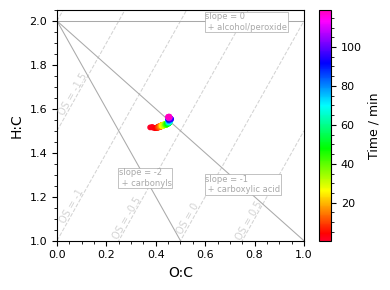

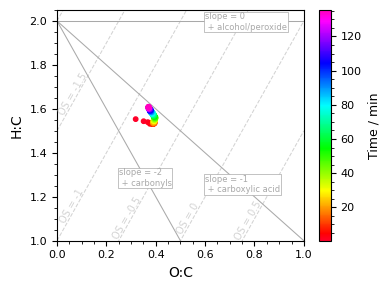

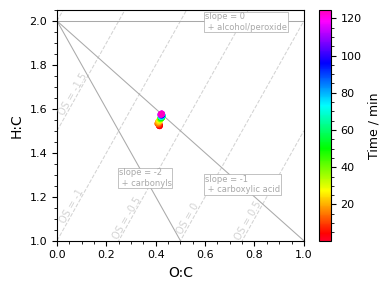

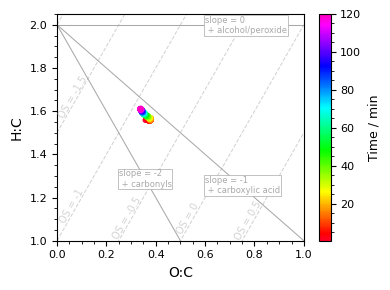

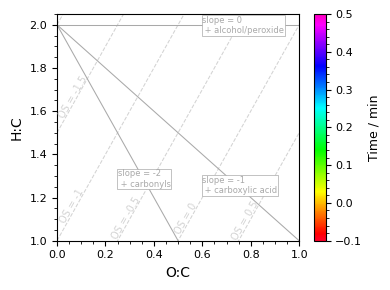

In [4]:
timestamps = [['2025-08-20 10:10', '2025-08-20 12:25'],
              ['2025-08-22 10:20', '2025-08-22 12:48'],
              ['2025-08-25 09:27', '2025-08-25 11:37'],
              ['2025-08-26 09:36', '2025-08-26 11:42'],
              ['2025-08-28 09:07', '2025-08-26 12:00']]

for key, time in zip(AMS.keys(), timestamps):
    fig, ax = plot_VanKrevelen(AMS[key], ['Ratio_H_C_all_IA', 'Ratio_O_C_all_IA'], time, 0.5)
    fig.tight_layout()
    fig.savefig(f'vanKrevelen_{key}.jpg', dpi = 600)